 # KF7032 Assignment Part 3
- Name: Lee Walton
- Student Number: 17007224
- Course: (MComp) Computer Science with Web Development

Datasets Used: all_crimes18_hdr.txt.gz and LSOA_pop_v2.csv

## Introduction
This big data report is on crime in the UK specifically violent crimes and drugs. The report will be evaluating claims made in a television documentary "Ross Kemp and the Armed Police" broadcast on ITV 6th September 2018. 
The claims were:

1. Violent Crime is increasing
2. There are more firearms incidents per head in Birmingham than anywhere else in the UK
3. Crimes involving firearms are closely associated with drugs offences

In the documentary Ross Kemp speaks to a group of individuals from one of the biggest gangs in Birmingham who disclose that they first handled guns at the age of 15 and that there are some children these days are a lot younger when they first get involved in gun crime. Another gang member also discloses that they can get access to a gun within a quarter of an hour with just one phone call (Ross Kemp and The Armed Police, 2018).

Crime analysis is an important process so that the government and police forces can maintain law and order (Jain and Bhatnagar, 2016). Being able to process large amounts of data to extract meaningful information (Jain and Bhatnagar, 2016), means that specific crime types can become the target of enforcement strategies if they are identified as areas of concern. Furthermore, by including location-based data and aggregating data on location the allocation of police forces can be carefully planned to increase in areas that have more demand for officers. 

To solve this problem multiple techniques will have to be used to derive the statistics from the raw dataset. Python Spark with data frames and the Pandas library will be used to solve the problem. Each of the statements will then be answered using Spark SQL functions such as groupBy, count, select and multiple statistical methods. Visualisation techniques such as bar charts to display values, time series graphs to show change in crime over time and scatter plots to demonstrate reltionships between crimes wil be used throughout the report. Correlation will also be used to measure the extent of relation between crime types or crime and population (Nolan, 2004). Using a combination of these data aggregation, visualisation, and statistical methods all three statements can be analysed.

### Configuration and imports
First we must import the main libaries being used such as pandas, pyspark and numpy. Then we must set the spark context and spark session before we make any dataframes or attempt to use any functions.

In [1]:
##import statements
import pyspark #pyspark
from pyspark import SparkContext, SparkConf #config and context
import pyspark.sql.functions as func #built in dataframe functions

In [2]:
try:
    conf = SparkConf().setMaster("local").setAppName("assignment3") #config
    sc = SparkContext(conf = conf) #context run once
except:
    print("Spark context allready exists")

In [3]:
sc #check context

<SparkContext master=local appName=assignment3>

In [4]:
##sql context
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

In [5]:
##setup spark session
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.appName("Assignment Notebook")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

In [6]:
%matplotlib inline #show graphs in notebook

In [7]:
#import pandas
import pandas as pd

#import numpy and pyplot
import numpy as np
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt

### Import and parse datasets

We must link the data files and load their content into variables and create functions to parse the required fields. One function below is used to remove the header row (if needed) and can be called with the datafile as input. This will be done prior to creating a data frame.

Parse Crime is a function to parse the crime dataset the fields ‘Month’, ‘LSOA’ and ‘CrimeType’ are selected as the required fields. Month is needed for any time series graph to answer time related questions and LSOA to join the population dataset. Finally, the crime type is required so that we can filter by the correct crime types to answer the 3 statements as referred to in the introduction. 

Parsepop is the function to parse the population LSOA dataset. From which we extract the columns ‘Geography’, ‘GeographyCode’ and ‘Variable: All usual residents’. Geography code links to LSOA code which is a regional code used to identify regions of the UK this will be used to join the crime dataset to the population dataset. Geography contains the Local Authority (region) Name and partial code this field is needed to get the area name however when parsed, it is important to remove the code from this field so that the identifying region name only remains. To do this the rsplit function can be used to remove the 4 digits on the end of the field, which allows us to group by Local Area Name for the location-based tasks. Finally, all usual residents will be used to calculate the population using the sum function to sum all the sub locations for a city which will be used to answer statement 2 for incidents per head per population of each city.

It is best practise to select only the fields needed to reduce the amount of data in the RDD or data frame and therefore speed up the time taken to process. It is also important to parse the fields correctly so that the data is in the correct format for processing.

In [8]:
#Load data files
crimeSrc = sc.textFile("all_crimes18_hdr.txt.gz") #load crime data 
populationSrc = sc.textFile("LSOA_pop_v2.csv") #load location data
deprivationSrc = sc.textFile("deprivation_with_hdr.gz") #load data

In [9]:
#function to parse data
def parseCrime(line):
    fields = line.split(',') #split fields by comma because csv format
    #parse date
    Month = fields[1]
    LSOA = fields[7]
    CrimeType = fields[9]
    return (Month,LSOA,CrimeType)

In [10]:
#function to parse data
def parsePop(line):
    fields = line.split(',') #split fields by comma because csv format
    Geography = fields[1].rsplit(' ', 1)[0] #remove 4-digit code from field so place name remains
    GeographyCode = fields[2]
    PopulationStr = fields[4]
    AllResidents = int(PopulationStr)
    return (Geography,GeographyCode,AllResidents)

### Remove Header and Check Files

In [12]:
#function to remove header line
def removeHead(lines):
    #filter header line of txt file
    header = lines.first() #store header in var
    justdata = lines.filter(lambda row: row != header) #seperate data
    return justdata #return only the data

In [14]:
#check dataset and get layout/format
crimeSrc.take(5)

['Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,',
 ',2010-12,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,,']

In [15]:
#remove header
crimeSrc = removeHead(crimeSrc)
#map crimes data
rddCrimes = crimeSrc.map(parseCrime) #create rdd
#rddCrimes.count() #check all data is present

In [16]:
#test data is parsed and only required fields remain
rddCrimes.take(5)

[('2010-12', 'E01017662', 'Other crime'),
 ('2010-12', 'E01014399', 'Anti-social behaviour'),
 ('2010-12', 'E01014399', 'Anti-social behaviour'),
 ('2010-12', 'E01014399', 'Anti-social behaviour'),
 ('2010-12', 'E01014399', 'Anti-social behaviour')]

### Create Dataframe for Crime Dataset

In [17]:
##import types
from pyspark.sql.types import StructType,IntegerType,StructType,StringType
from pyspark.sql.types import *
##Define df schema
schemaA = StructType(
    [StructField("Month", StringType(), True),
    StructField("LSOA", StringType(), True),
    StructField("CrimeType", StringType(), True)])
#create dataframe for crimes using schema
dfCrimes = sqlCtx.createDataFrame(rddCrimes, schemaA) #create dataframe using defined schema

In [18]:
dfCrimes.show() #check structure

+-------+---------+--------------------+
|  Month|     LSOA|           CrimeType|
+-------+---------+--------------------+
|2010-12|E01017662|         Other crime|
|2010-12|E01014399|Anti-social behav...|
|2010-12|E01014399|Anti-social behav...|
|2010-12|E01014399|Anti-social behav...|
|2010-12|E01014399|Anti-social behav...|
|2010-12|E01014399|Anti-social behav...|
|2010-12|E01014399|            Burglary|
|2010-12|E01014399|            Burglary|
|2010-12|E01014399|         Other crime|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|Anti-social behav...|
|2010-12|E01014400|            Burglary|
|2010-12|E01014400|            Burglary|
|2010-12|E01014400|            Burglary|
|2010-12|E01014400|            Burglary|
|2010-12|E01014400|       Vehicle crime|
+-------+---------+--------------------+
only showing top

In [19]:
dfCrimes.printSchema() #check schema

root
 |-- Month: string (nullable = true)
 |-- LSOA: string (nullable = true)
 |-- CrimeType: string (nullable = true)



In [20]:
#group by crime type to find out possible crime types
allCrimeTypes = dfCrimes.groupBy("CrimeType")\
.count()\
.sort("CrimeType", ascending=True)

In [21]:
allCrimeTypes.take(50) #list of crime types to inform filtering of data

[Row(CrimeType='', count=31),
 Row(CrimeType='Anti-social behaviour', count=15876047),
 Row(CrimeType='Bassetlaw 008B', count=8),
 Row(CrimeType='Bicycle theft', count=502391),
 Row(CrimeType='Blaby 013C', count=41),
 Row(CrimeType='Burglary', count=3407977),
 Row(CrimeType='Charnwood 012C', count=30),
 Row(CrimeType='Charnwood 021E', count=375),
 Row(CrimeType='Charnwood 022D', count=28),
 Row(CrimeType='Criminal damage and arson', count=3885733),
 Row(CrimeType='Drugs', count=1163886),
 Row(CrimeType='Hillingdon 009E', count=17),
 Row(CrimeType='Hillingdon 011C', count=125),
 Row(CrimeType='Other crime', count=2271304),
 Row(CrimeType='Other theft', count=3956838),
 Row(CrimeType='Possession of weapons', count=159023),
 Row(CrimeType='Public disorder and weapons', count=242141),
 Row(CrimeType='Public order', count=1319234),
 Row(CrimeType='Robbery', count=490235),
 Row(CrimeType='Shoplifting', count=2375482),
 Row(CrimeType='Theft from the person', count=477461),
 Row(CrimeType='Veh

### Create sub dataframes for each type of crime required
This includes violent crime for task 1 and 2 and drug/weapon crime for task 3

In [22]:
#create subsets for violence, drugs and weapons as all are needed to answer questions
#using the "pipe" or | vertical line allows multiple criteria similar to "OR" in sql
#Filter violent crime using closest available crime types
vlntCrime = dfCrimes.filter((dfCrimes.CrimeType == "Violence and sexual offences") | (dfCrimes.CrimeType == "Violent crime"))
#Drugs
drugCrime = dfCrimes.filter(dfCrimes.CrimeType == "Drugs")
#Firearms related - weapon crimes are the closest crime to firearms therefore we must use these crime types instead
weaponCrime = dfCrimes.filter((dfCrimes.CrimeType == "Possession of weapons") | (dfCrimes.CrimeType == "Public disorder and weapons"))

### Process violent crime dataframe to create time series graph

In [23]:
#we only need violent crime for now
vlntCrime.count() #check count

7806517

In [24]:
#group by month, count monthly tests and sort by count so we have monthly totals for graph
monthlyVlntC = vlntCrime.groupBy("Month")\
.count()\
.sort("Month", ascending=True)

In [25]:
#rename columns
newColumns = ["Month","Incidents"]
monthlyVlntRn = monthlyVlntC.toDF(*newColumns)
#Check types
monthlyVlntRn.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Incidents: long (nullable = false)



In [26]:
monthlyVlntRn.show() #view data structure is as expected

+-------+---------+
|  Month|Incidents|
+-------+---------+
|2010-12|    57580|
|2011-01|    59823|
|2011-02|    56686|
|2011-03|    62326|
|2011-04|    64297|
|2011-05|    63633|
|2011-06|    62473|
|2011-07|    66570|
|2011-08|    63284|
|2011-09|    57149|
|2011-10|    60076|
|2011-11|    56894|
|2011-12|    56163|
|2012-01|    56324|
|2012-02|    50598|
|2012-03|    58606|
|2012-04|    53415|
|2012-05|    59539|
|2012-06|    56816|
|2012-07|    60199|
+-------+---------+
only showing top 20 rows



In [27]:
#convert to pandas
monthlyVlntC_PD = monthlyVlntRn.toPandas()
monthlyVlntC_PD

,Month,Incidents
0,2010-12,57580
1,2011-01,59823
2,2011-02,56686
3,2011-03,62326
4,2011-04,64297
...,...,...
87,2018-03,140964
88,2018-04,142115
89,2018-05,158058
90,2018-06,156091


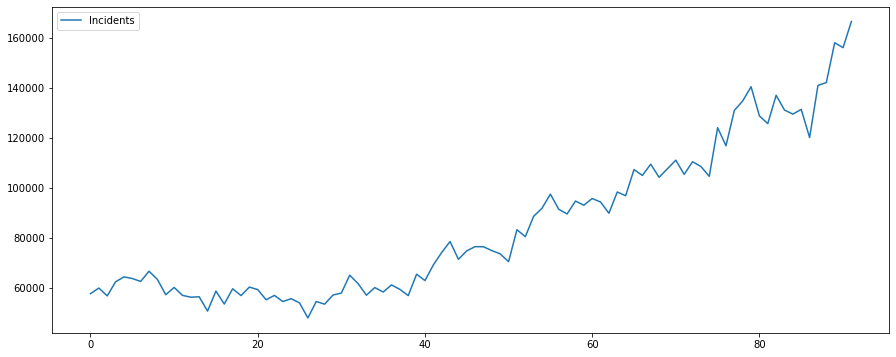

In [28]:
#import graph libaries and set figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from pandas import Series
from matplotlib import pyplot

#plot basic data
monthlyVlntC_PD.plot()
pyplot.show()

In [29]:
#Calculate rolling average
rollingAvgVlnt = monthlyVlntC_PD.rolling(12).mean()

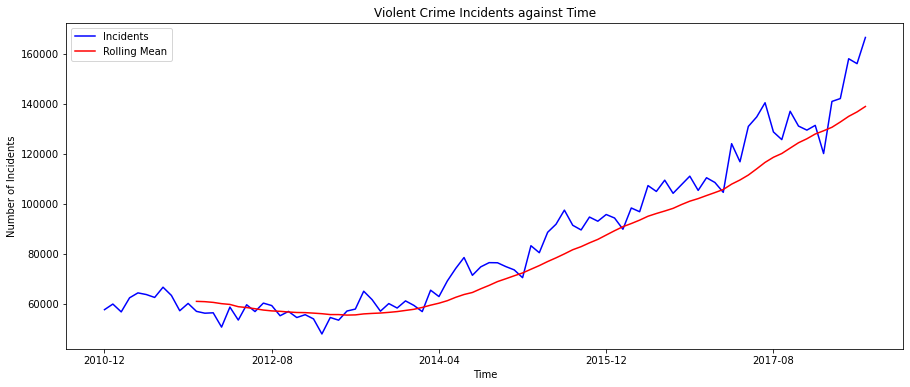

In [30]:
vlntLinePlot = monthlyVlntC_PD.plot(x="Month", y="Incidents", color='blue') #plot monthly incidents
mean = plt.plot(rollingAvgVlnt, color='red', label='Rolling Mean') #plot rolling average 
plt.legend(loc='best')
#set labels
plt.ylabel("Number of Incidents")
plt.xlabel("Time")
plt.title("Violent Crime Incidents against Time")
plt.show(block=False)
pyplot.show() #display graph

## Answer 1: Is violent crime increasing?

The first statement made is that violent crime is increasing. To determine if this is correct, we must first select which dataset we need to answer this, since the statement does not require any population data to answer the only dataset needed is the crimes dataset. Earlier in the processing stage we filtered the dataset into sub data frames for violent, drug and weapon crimes, for this section we used the violent crime sub dataset. Since the statement is related to time, we will select the date or “month” as the data field that we will need to group by. The other data we need is the number of violent crimes this is calculated by using the count function in spark SQL. The result is a table of the months within the dataset and the number of crimes for each month. This data will then be plotted on a time series graph using Pandas and Matplotlib to show the change in violent crime over time. Time series is the preferred graph for Time related data explains (Doorman and Gravemeijer, 2008), this is because they display visually the rate of change and peaks and troughs clearly as opposed to tables of data. This means that reasoning on data can more easily be given.

The graph shows a clear rolling average that increases with time which proves the statement "Violent Crime is Increasing". While the first months from 2010 to 2014 have a small decrease after 2014 violent crime starts to increase at a steady rate as shown by the rolling average. This is backed up by a report published by the Office for National Statistics (Ellis, 2021), which says that there has been a rise in certain crime types such as violent crime and sexual offences.

### Parse LSOA dataset and create population dataframe

In [31]:
populationSrc.take(5)#check data present

['"date","geography","geography code","Rural Urban","Variable: All usual residents; measures: Value","Variable: Males; measures: Value","Variable: Females; measures: Value","Variable: Lives in a household; measures: Value","Variable: Lives in a communal establishment; measures: Value","Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value","Variable: Area (Hectares); measures: Value","Variable: Density (number of persons per hectare); measures: Value"',
 '2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4',
 '2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1',
 '2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3',
 '2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3']

In [32]:
#map crimes data
popData = removeHead(populationSrc) #remove header
rddPop = popData.map(parsePop) #parse data andcreate rdd

In [33]:
#check data
rddPop.take(200)

[('Darlington', 'E01012334', 2466),
 ('Darlington', 'E01012335', 1383),
 ('Darlington', 'E01012366', 2008),
 ('Darlington', 'E01033481', 1364),
 ('Darlington', 'E01033482', 1621),
 ('Darlington', 'E01012323', 1563),
 ('Darlington', 'E01012324', 1399),
 ('Darlington', 'E01032545', 1259),
 ('Darlington', 'E01032546', 1776),
 ('Darlington', 'E01012328', 1571),
 ('Darlington', 'E01012329', 1770),
 ('Darlington', 'E01012330', 1145),
 ('Darlington', 'E01012331', 1255),
 ('Darlington', 'E01012349', 1532),
 ('Darlington', 'E01012350', 1517),
 ('Darlington', 'E01012351', 1438),
 ('Darlington', 'E01012352', 1579),
 ('Darlington', 'E01012325', 1456),
 ('Darlington', 'E01012326', 1129),
 ('Darlington', 'E01012332', 1427),
 ('Darlington', 'E01012333', 1451),
 ('Darlington', 'E01012309', 1858),
 ('Darlington', 'E01012310', 1960),
 ('Darlington', 'E01012311', 1567),
 ('Darlington', 'E01012312', 1351),
 ('Darlington', 'E01012313', 1402),
 ('Darlington', 'E01012314', 1364),
 ('Darlington', 'E01012362',

In [34]:
#Create dataframe
schemaB = StructType(
    [StructField("Geography", StringType(), True),
    StructField("GeographyCode", StringType(), True),
    StructField("AllResidents", IntegerType(), True)])
#create dataframe for crimes using schema
dfPop = sqlCtx.createDataFrame(rddPop, schemaB) #create dataframe using defined schema

In [35]:
dfPop.show()#check structure

+----------+-------------+------------+
| Geography|GeographyCode|AllResidents|
+----------+-------------+------------+
|Darlington|    E01012334|        2466|
|Darlington|    E01012335|        1383|
|Darlington|    E01012366|        2008|
|Darlington|    E01033481|        1364|
|Darlington|    E01033482|        1621|
|Darlington|    E01012323|        1563|
|Darlington|    E01012324|        1399|
|Darlington|    E01032545|        1259|
|Darlington|    E01032546|        1776|
|Darlington|    E01012328|        1571|
|Darlington|    E01012329|        1770|
|Darlington|    E01012330|        1145|
|Darlington|    E01012331|        1255|
|Darlington|    E01012349|        1532|
|Darlington|    E01012350|        1517|
|Darlington|    E01012351|        1438|
|Darlington|    E01012352|        1579|
|Darlington|    E01012325|        1456|
|Darlington|    E01012326|        1129|
|Darlington|    E01012332|        1427|
+----------+-------------+------------+
only showing top 20 rows



In [36]:
#group by location and calculate the total population using the sum of all residents for each record for all locations
locationPopulations = dfPop.groupBy("Geography")\
.sum("AllResidents")\
.sort("Geography", ascending=True)

In [37]:
locationPopulations.show() #check result

+--------------------+-----------------+
|           Geography|sum(AllResidents)|
+--------------------+-----------------+
|                Adur|            61182|
|           Allerdale|            96422|
|        Amber Valley|           122309|
|                Arun|           149518|
|            Ashfield|           119497|
|             Ashford|           117956|
|      Aylesbury Vale|           174137|
|             Babergh|            87740|
|Barking and Dagenham|           185911|
|              Barnet|           356386|
|            Barnsley|           231221|
|   Barrow-in-Furness|            69087|
|            Basildon|           174497|
|Basingstoke and D...|           167799|
|           Bassetlaw|           112863|
|Bath and North Ea...|           176016|
|             Bedford|           157479|
|              Bexley|           231997|
|          Birmingham|          1073045|
|               Blaby|            93915|
+--------------------+-----------------+
only showing top

In [38]:
#rename columns for later reference
newColumns = ["Location","Population"]
locations = locationPopulations.toDF(*newColumns)

In [39]:
locations.show() #check cols

+--------------------+----------+
|            Location|Population|
+--------------------+----------+
|                Adur|     61182|
|           Allerdale|     96422|
|        Amber Valley|    122309|
|                Arun|    149518|
|            Ashfield|    119497|
|             Ashford|    117956|
|      Aylesbury Vale|    174137|
|             Babergh|     87740|
|Barking and Dagenham|    185911|
|              Barnet|    356386|
|            Barnsley|    231221|
|   Barrow-in-Furness|     69087|
|            Basildon|    174497|
|Basingstoke and D...|    167799|
|           Bassetlaw|    112863|
|Bath and North Ea...|    176016|
|             Bedford|    157479|
|              Bexley|    231997|
|          Birmingham|   1073045|
|               Blaby|     93915|
+--------------------+----------+
only showing top 20 rows



In [40]:
locations.count() #count locations

348

### Join weapon crime and LSOA

In [41]:
#Check weapon crime sub dataset 
weaponCrime.show(5)

+-------+---------+--------------------+
|  Month|     LSOA|           CrimeType|
+-------+---------+--------------------+
|2011-09|E01014370|Public disorder a...|
|2011-09|E01014473|Public disorder a...|
|2011-09|E01014418|Public disorder a...|
|2011-09|E01014690|Public disorder a...|
|2011-09|E01014497|Public disorder a...|
+-------+---------+--------------------+
only showing top 5 rows



In [42]:
#check fields available in population dataset
dfPop.show(5)

+----------+-------------+------------+
| Geography|GeographyCode|AllResidents|
+----------+-------------+------------+
|Darlington|    E01012334|        2466|
|Darlington|    E01012335|        1383|
|Darlington|    E01012366|        2008|
|Darlington|    E01033481|        1364|
|Darlington|    E01033482|        1621|
+----------+-------------+------------+
only showing top 5 rows



In [43]:
#join datasets using fields containing LSOA code
crimeJoinLocation = weaponCrime.join(dfPop, weaponCrime.LSOA == dfPop.GeographyCode)

In [44]:
crimeJoinLocation.printSchema() #check fields have joined

root
 |-- Month: string (nullable = true)
 |-- LSOA: string (nullable = true)
 |-- CrimeType: string (nullable = true)
 |-- Geography: string (nullable = true)
 |-- GeographyCode: string (nullable = true)
 |-- AllResidents: integer (nullable = true)



In [45]:
#select only relevent fields for crimes and location names
crimeLocation = crimeJoinLocation.select("Month","Geography","CrimeType")

In [46]:
crimeLocation.show()

+-------+--------------------+--------------------+
|  Month|           Geography|           CrimeType|
+-------+--------------------+--------------------+
|2011-11|Barking and Dagenham|Public disorder a...|
|2012-01|Barking and Dagenham|Public disorder a...|
|2012-02|Barking and Dagenham|Public disorder a...|
|2012-02|Barking and Dagenham|Public disorder a...|
|2012-07|Barking and Dagenham|Public disorder a...|
|2012-10|Barking and Dagenham|Public disorder a...|
|2013-03|Barking and Dagenham|Public disorder a...|
|2014-12|Barking and Dagenham|Possession of wea...|
|2015-03|Barking and Dagenham|Possession of wea...|
|2016-06|Barking and Dagenham|Possession of wea...|
|2016-08|Barking and Dagenham|Possession of wea...|
|2017-08|Barking and Dagenham|Possession of wea...|
|2017-08|Barking and Dagenham|Possession of wea...|
|2018-05|Barking and Dagenham|Possession of wea...|
|2012-03|              Barnet|Public disorder a...|
|2012-06|              Barnet|Public disorder a...|
|2012-11|   

In [47]:
#group crime by local authority region name and count number of incidents
weaponGroupByLocation = crimeLocation.groupBy("Geography")\
.count()\
.sort("count", ascending=False)

In [48]:
weaponGroupByLocation.show() #check result

+-------------------+-----+
|          Geography|count|
+-------------------+-----+
|         Birmingham| 9317|
|         Manchester| 7552|
|              Leeds| 5949|
|          Liverpool| 5480|
|        Westminster| 5390|
|           Bradford| 4282|
|         Nottingham| 4273|
|            Lambeth| 4266|
|          Sheffield| 3986|
|          Leicester| 3945|
|          Southwark| 3734|
|             Camden| 3647|
|              Brent| 3510|
|            Cardiff| 3434|
|          Islington| 3383|
|         Uttlesford| 3265|
|             Newham| 3231|
|Newcastle upon Tyne| 3222|
|      Tower Hamlets| 3218|
|             Ealing| 3197|
+-------------------+-----+
only showing top 20 rows



In [49]:
#weaponGroupByLocation.count() #check count

In [50]:
#rename columns ready for join later
newColumns = ["CrimeLocation","WeaponCrimes"]
weaponGroupByLocationRn = weaponGroupByLocation.toDF(*newColumns)

In [51]:
weaponGroupByLocationRn.show() #check cols

+-------------------+------------+
|      CrimeLocation|WeaponCrimes|
+-------------------+------------+
|         Birmingham|        9317|
|         Manchester|        7552|
|              Leeds|        5949|
|          Liverpool|        5480|
|        Westminster|        5390|
|           Bradford|        4282|
|         Nottingham|        4273|
|            Lambeth|        4266|
|          Sheffield|        3986|
|          Leicester|        3945|
|          Southwark|        3734|
|             Camden|        3647|
|              Brent|        3510|
|            Cardiff|        3434|
|          Islington|        3383|
|         Uttlesford|        3265|
|             Newham|        3231|
|Newcastle upon Tyne|        3222|
|      Tower Hamlets|        3218|
|             Ealing|        3197|
+-------------------+------------+
only showing top 20 rows



### Join Location Population dataframe and Location Crime count dataframe

In [52]:
#Join on common field which is the Local Authority Region name (Geography and Location fields)
weaponCrimeWithPopulation = weaponGroupByLocationRn.join(locations,locations.Location == weaponGroupByLocationRn.CrimeLocation)

In [53]:
weaponCrimeWithPopulation #check result

DataFrame[CrimeLocation: string, WeaponCrimes: bigint, Location: string, Population: bigint]

In [54]:
#Select only the needed fields Location, Population and WeaponCrimes
#Calculate resultant crime rate of population and crimes for number of crimes per 100,000 population
weaponCrimeWithPopulationRatio = weaponCrimeWithPopulation.select("Location","Population","WeaponCrimes",((weaponCrimeWithPopulation["WeaponCrimes"]/weaponCrimeWithPopulation["Population"])*100000))

In [55]:
#rename cols
newColumns = ["Location","Population","WeaponCrimes","CrimeRate"]
weaponCrimeWithPopulationRatioRn = weaponCrimeWithPopulationRatio.toDF(*newColumns)

In [56]:
weaponCrimeWithPopulationRatioRn.show() #check new cols

+--------------------+----------+------------+------------------+
|            Location|Population|WeaponCrimes|         CrimeRate|
+--------------------+----------+------------+------------------+
|           Worcester|     98768|        1214|1229.1430422809008|
|           Charnwood|    166100|        1170| 704.3949428055389|
|      North Kesteven|    107766|         224|207.85776590019114|
|                Arun|    149518|        1023| 684.1985580331465|
|       Epping Forest|    124659|         723| 579.9821914181888|
|             Waveney|    115254|         939| 814.7222656046645|
|              Stroud|    112779|         331| 293.4943562187996|
|              Maldon|     61629|         169| 274.2215515422934|
|          New Forest|    176462|         806| 456.7555621040224|
|           Sedgemoor|    114588|         190|165.81142877090096|
|           Guildford|    137183|         916| 667.7212191014922|
|            Worthing|    104640|         823| 786.5061162079511|
|         

In [57]:
#round crime rate column to 2 decimal places
weaponCrimeWithPopulationRatioRn = weaponCrimeWithPopulationRatioRn.withColumn("CrimeRate", func.round(weaponCrimeWithPopulationRatioRn["CrimeRate"],2))

In [58]:
#convert to dataframe
weaponWithPopulation_PD = weaponCrimeWithPopulationRatioRn.toPandas()
#sort dataframe by highest crime rate
weaponWithPopulation_PD = weaponWithPopulation_PD.sort_values(by='CrimeRate', ascending=False)

In [59]:
weaponWithPopulation_PDBAR = weaponWithPopulation_PD.head(30) #take top 30 locations

In [60]:
weaponWithPopulation_PDBAR #chceck results

,Location,Population,WeaponCrimes,CrimeRate
324,City of London,7375,788,10684.75
32,Uttlesford,79443,3265,4109.86
189,Westminster,219396,5390,2456.74
72,Camden,220338,3647,1655.18
145,Islington,206125,3383,1641.24
126,Crawley,106597,1710,1604.17
257,Hammersmith and Fulham,182493,2759,1511.84
30,Manchester,503127,7552,1501.01
267,Ipswich,133384,1974,1479.94
45,Lambeth,303086,4266,1407.52


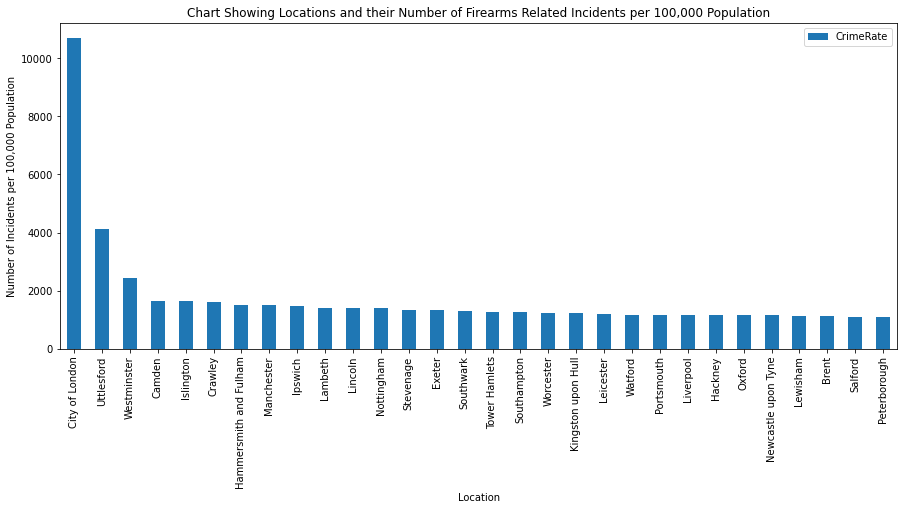

In [61]:
#plot top 30 locations on barchart for comparisons
#define data and rotate labels sideways
weaponBarChart = weaponWithPopulation_PDBAR.plot.bar(x='Location', y='CrimeRate', rot=90)
#define labels
plt.ylabel("Number of Incidents per 100,000 Population")
plt.xlabel("Location")
plt.title("Chart Showing Locations and their Number of Firearms Related Incidents per 100,000 Population")
#display graph
plt.show(block=False)
pyplot.show()

## Answer 2: There are more firearms incidents in Birmingham than anywhere in the UK

To answer the second statement the populations of Local Authorities in the UK were calculated. The number of firearms related incidents for each local authority were also calculated. These figures were used to calculate rate of the population for the regions for example per 100,000 population.

The final figure of **CrimeRate** is calculated by dividing the number of crimes by the total population and instead of multiplying by 100 to give a percentage (out of 100) has been multiplied by 100,000 to give the rate as a per 100,000 of the population instead of 100. The main reason for using 100,000 was because a traditional percentage would result in a very small number.

One factor to consider is that the answer uses the number of crime incidents for weapons from the whole dataset as the statement made does not define a certain time frame or year. Therefore, cannot prove the statements made by Ross Kemp as true or false as we do not know which timeframe the results are based on. For example, one-year Birmingham may have the largest firearms incidents per head one year and the next year London may have a higher rate. Birmingham is known for high levels of gang crime says (Hales, Lewis and Silverstone, 2006), as a result this lends itself to high availability of firearms.

As shown in the bar chart and table Birmingham is not in the top 30. However, it is not far from based on the population and crime count data frames Birmingham has one of the largest populations at 1073045 and the number of weapon crimes is at 9317 therefore the crime rate is 868 weapon related crimes per 100,000 population. This is just shy of the 1000’s which the top 30 regions lie within. Therefore, Birmingham is on the edge of the top 10% because the number of Local Authorities categorise into over 300 locations. 

Since the documentary was made 3 years ago and it did not specify a time it is possible that the data used was limited or did not contain the most recent published data. The results show that The City of London has the largest Violent Weapon crime rate this is possibly because of the growing population of London as estimated by (London City Hall, 2021) by 2020 there is estimated to be more Londoners than at any time in the city’s history.

### Group by month and count crimes for weapons and drugs sub datasets

In [62]:
#group weapon related incidents by month and count for the number of incidents
monthlyWeaponIncidents = weaponCrime.groupBy("Month")\
.count()\
.sort("Month", ascending=False) #sort descending

In [63]:
#rename columns
newColumns = ["Month1","WeaponIncidents"]
monthlyWeaponIncidentsRn = monthlyWeaponIncidents.toDF(*newColumns)

In [64]:
monthlyWeaponIncidentsRn.show() #check output

+-------+---------------+
| Month1|WeaponIncidents|
+-------+---------------+
|2018-07|           3970|
|2018-06|           3928|
|2018-05|           4175|
|2018-04|           3921|
|2018-03|           3755|
|2018-02|           3389|
|2018-01|           3508|
|2017-12|           3086|
|2017-11|           3464|
|2017-10|           3648|
|2017-09|           3394|
|2017-08|           3563|
|2017-07|           3686|
|2017-06|           3656|
|2017-05|           3633|
|2017-04|           3159|
|2017-03|           3348|
|2017-02|           2847|
|2017-01|           2737|
|2016-12|           2628|
+-------+---------------+
only showing top 20 rows



In [65]:
#group drug related incidents by month and count for the number of incidents
monthlyDrugIncidents = drugCrime.groupBy("Month")\
.count()\
.sort("Month", ascending=False) #sort descending

In [66]:
#rename columns
newColumns = ["Month2","DrugIncidents"]
monthlyDrugIncidentsRn = monthlyDrugIncidents.toDF(*newColumns)

In [67]:
monthlyDrugIncidentsRn.show() #check output

+-------+-------------+
| Month2|DrugIncidents|
+-------+-------------+
|2018-07|        11076|
|2018-06|        11645|
|2018-05|        12272|
|2018-04|        12082|
|2018-03|        11662|
|2018-02|        11416|
|2018-01|        12082|
|2017-12|        11264|
|2017-11|        12198|
|2017-10|        12367|
|2017-09|        11227|
|2017-08|        12009|
|2017-07|        11925|
|2017-06|        10688|
|2017-05|        11277|
|2017-04|        10707|
|2017-03|        11938|
|2017-02|        10221|
|2017-01|        10997|
|2016-12|        11222|
+-------+-------------+
only showing top 20 rows



### Join Weapon and Drug monthly totals for scatter

In [68]:
#join both the count of weapons and drugs dataframes so that both can be plotted on same graph
#join by month1 and month2 which correspond to the same dates to show relation between crime types
weaponDrugJoin = monthlyWeaponIncidentsRn.join(monthlyDrugIncidentsRn,monthlyWeaponIncidentsRn.Month1 == monthlyDrugIncidentsRn.Month2)

In [69]:
#select needed fields and sort by month
weaponVsDrug = weaponDrugJoin.select("Month1","WeaponIncidents","DrugIncidents").sort("Month1", ascending=False)
weaponVsDrug.show() #check output

+-------+---------------+-------------+
| Month1|WeaponIncidents|DrugIncidents|
+-------+---------------+-------------+
|2018-07|           3970|        11076|
|2018-06|           3928|        11645|
|2018-05|           4175|        12272|
|2018-04|           3921|        12082|
|2018-03|           3755|        11662|
|2018-02|           3389|        11416|
|2018-01|           3508|        12082|
|2017-12|           3086|        11264|
|2017-11|           3464|        12198|
|2017-10|           3648|        12367|
|2017-09|           3394|        11227|
|2017-08|           3563|        12009|
|2017-07|           3686|        11925|
|2017-06|           3656|        10688|
|2017-05|           3633|        11277|
|2017-04|           3159|        10707|
|2017-03|           3348|        11938|
|2017-02|           2847|        10221|
|2017-01|           2737|        10997|
|2016-12|           2628|        11222|
+-------+---------------+-------------+
only showing top 20 rows



### Plot scatter of Weapons vs Drugs

In [70]:
#convert to pandas
weaponVsDrug_PD = weaponVsDrug.toPandas()

In [71]:
#import statistics library
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

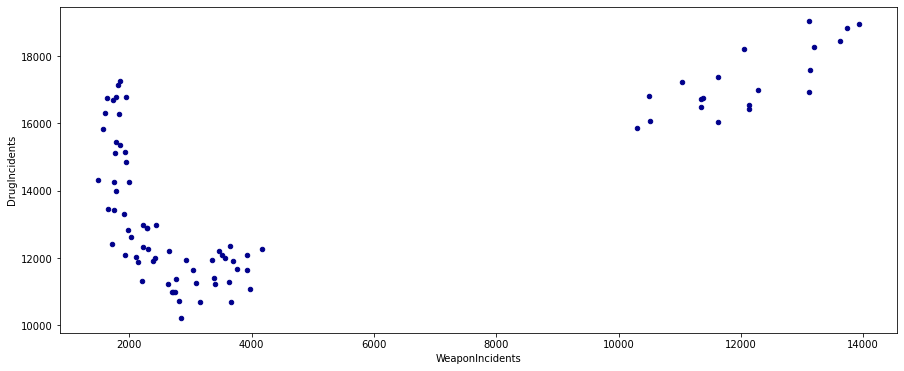

In [73]:
#create scatterplot using weapon incidents as x and drug incidents as y axis
sc1 = weaponVsDrug_PD.plot.scatter(x='WeaponIncidents', y='DrugIncidents', c='DarkBlue')

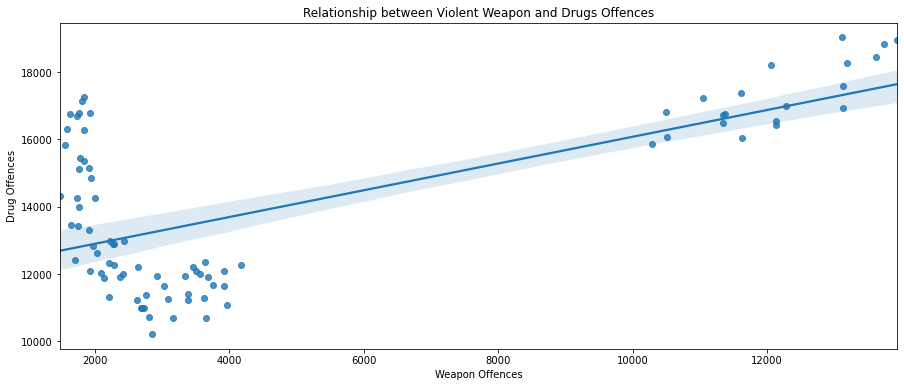

In [74]:
#use seaborn to get trendline
import seaborn as sns
#define x and y values and dataframe
sc2 =sns.regplot(x='WeaponIncidents', y='DrugIncidents', data = weaponVsDrug_PD)
#add labels
plt.ylabel("Drug Offences")
plt.xlabel("Weapon Offences")
plt.title("Relationship between Violent Weapon and Drugs Offences")
#display graph
plt.show(block=False)
pyplot.show()

### Calculate Correlation

In [75]:
#Convert pandas columns to arrays

#map weapons values to array
weaponsCorr = weaponVsDrug.rdd.map(lambda v: v[1])

#map drugs values to array
drugsCorr = weaponVsDrug.rdd.map(lambda v: v[2])

In [76]:
#calculate and print pearson correlation

corP = Statistics.corr(weaponsCorr,drugsCorr,"pearson") # default
print("Weapons Vs Drugs : Pearson Correlation = %2.4f" % corP)

#calculate and print spearman correlation

corS = Statistics.corr(weaponsCorr,drugsCorr,"spearman") # Need to specify
print("Weapons Vs Drugs : Spearman Correlation = %2.4f" % corS)

Weapons Vs Drugs : Pearson Correlation = 0.6585
Weapons Vs Drugs : Spearman Correlation = 0.1575


## Answer 3: Crimes involving firearms are closely associated with drugs offences

To produce the scatterplot shown the respective Drug offences and Violent Weapon offences data frames were grouped by the month and the number of crimes counted. Both resultant tables were then Joined by month to result in a data frame containing Month and the number of Weapons and Drugs related incidents. The numbers for weapons and drugs incidents were then plotted to show their relationship. 

As shown in the scatterplot there is an overall positive correlation as shown by the trend line. While the trend line ranges 13,000 to 17,000 on the y axis it spans across 1,000 to 12,000 approximately on the x axis. Since there is greater increase in x than y this shows that there is more substantial increase in Weapon offences than Drug offences. This suggests that drugs related offences have a higher impact on weapons incidents than weapon incidents have on drug offences. 

Further analysis that may be useful to undertake on the dataset could be to include further scatter plots for other comparisons between other crime types and weapon crimes to determine which has a larger relation to why weapons are carried or used. As suggested by a report from University College London (Marshall, Webb, Tilley and Dando, 2005), the most common crime type where guns are evident is robbery. As a result of this it may be useful to produce a scatterplot and correlation for Weapon offences and Robbery related offences.

Further analysis was carried out by calculating the Pearson and spearman correlations. While there are various methods to use to calculate correlation of various accuracy depending on the data used, (Nolan, 2004) investigates using similar methodology to determine the relationship between population and crime. Positive correlation values indicate a positive relationship says (Nolan, 2004), which is the case for all methods of calculating correlation. These values define to what extent there is a relationship between Weapons and Drugs while different methods may produce different numbers they are all positive for a positive correlation. The final correlation values were 0.658 and 0.157 for the Pearson and Spearman correlations, respectively. This means that since these values are positive there is a slight positive correlation between Weapon and Drugs crimes.

## Assumptions and Limitations

Some of the assumptions made because of limitations in the data provided include the substitution of weapon related incidents instead of firearms. This was because the big data available did not provide a crime type specifically for firearms and had no outcome data available, this meant there was no way to identify a suspected firearms incident. Another assumption made was that for statement one population has no impact on the increasing levels of crime. Furthermore, the population data provided was only for one given year and therefore when using population, it was assumed that population change from year to year has negligible impact on the results (United Kingdom population mid-year estimate - Office for National Statistics, 2021).


## Further Analysis Recommendations

The following are possible further routes of more detailed analysis that were out of the scope of the purpose of this report.

Further analysis could also be made regarding the increase in violent crime while the line graph shows the increase in violent crime over time, it does not consider the changing population. As published by the Office for National Statistics (United Kingdom population mid-year estimate - Office for National Statistics, 2021), over the past 10 years there has been a steady small increase in population in the region of 1.15 Million. One way this could be considered when analysing the data is through plotting a population line or calculating crime as a ratio of population. While overall crime levels are very useful to determine need for officers and policing levels, having the option to look at the rate of crime will show if crime is increasing due to the population increasing or another factor.

Another way that further analysis could have been carried out to compare violent crime across the towns and cities of the UK could be to map the data from the Violent Weapons Incidents, Population and Crime per 100,000 population data frame using libraries such as geopandas, map classify and leaflet this would allow for classification of crime rates across region to be colour coded using a key so that areas with a higher crime rate could be mapped out with darker colours. This visualisation method would greatly increase the ability to draw comparisons between different regions.

## Conclusions

Overall, most comments made in the TV documentary by Ross Kemp were correct. However due to some limitations in the data available and not knowing if the same datasets were used and assumptions as previously stated were made, we cannot say if the statements were true of false. 

To start overall the analysis carried out showed a significant increase in overall violent crime levels which backs up the comments made in the TV documentary. Since this question only refers to crime and there is only one main dataset for crime in the UK it is likely that the outcome is accurate. While the analysis done in this report did not make use of population figures to calculate a total crimes per population the population change over the time was negligible (United Kingdom population mid-year estimate - Office for National Statistics, 2021), therefore there would be little change to the results.

The analysis of the dataset also revealed that The City of London has the largest number of Weapon Crimes per 100,000 population. This does not match the statement made in the TV documentary that Birmingham has the largest number of Weapons incidents. However, the variance in this result may be due to the growing population of London (London City Hall, 2021). Since the statement made was based off data available 3-4 years ago and did not specify any timeframe this is likely the reason for the difference.

Finally, to conclude the final statement made regarding the close relationship between drugs and firearms incidents could not be proved as the dataset used only labels overall weapon crime. However, comparing drugs and weapons incidents does show the same expected result that there is a relationship which is positive. This shows that where there is an increase in drug crime where there are higher levels of this weapon crime significantly increases in proportion.

# References

Doorman, L. and Gravemeijer, K., 2008. Emergent modeling: discrete graphs to support the understanding of change and velocity. ZDM, 41(1-2), pp.199-211.

Ellis, K., 2021. Crime In England And Wales - Office For National Statistics. [online] Ons.gov.uk. Available at: <https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/bulletins/crimeinenglandandwales/yearendingjune2018> [Accessed 1 January 2021].

Hales, G., Lewis, C. and Silverstone, D., 2006. Gun Crime: The Market In And Use Of Illegal Firearms. Home Office Research, Development and Statistics Directorate.

Jain, A. and Bhatnagar, V., 2016. Crime Data Analysis Using Pig with Hadoop. Procedia Computer Science, 78, pp.571-578.

London City Hall. 2021. A Growing Population. [online] Available at: <https://www.london.gov.uk/what-we-do/planning/london-plan/current-london-plan/london-plan-chapter-one-context-and-strategy-0> [Accessed 5 January 2021].

Marshall, B., Webb, B., Tilley, N. and Dando, J., 2005. Rationalisation Of Current Research On Guns, Gangs And Other Weapons: Phase 1. [online] London: INSTITUTE OF CRIME SCIENCE, pp.p13-15. Available at: <http://www.nomsintranet.org.uk/roh/official-documents/Marshall_Webb_Tilly_gangs_and_guns_2005.pdf> [Accessed 1 January 2021].

Nolan, J., 2004. Establishing the statistical relationship between population size and UCR crime rate: Its impact and implications. Journal of Criminal Justice, 32(6), pp.547-555.

Nolan, J., 2004. Establishing the statistical relationship between population size and UCR crime rate: Its impact and implications. Journal of Criminal Justice, 32(6), pp.547-555.

Ons.gov.uk. 2021. United Kingdom Population Mid-Year Estimate - Office For National Statistics. [online] Available at: <https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/ukpop/pop> [Accessed 1 January 2021].

Ross Kemp and The Armed Police, 2018. [TV programme] ITV.